In [1]:
import numpy as np
from os.path import *
# from scipy.misc import imread
from imageio import imread
import cv2
import os
from PIL import Image
import json
import math
import dlib

TAG_CHAR = np.array([202021.25], np.float32)


def readFlow(fn):
    """ Read .flo file in Middlebury format"""
    # Code adapted from:
    # http://stackoverflow.com/questions/28013200/reading-middlebury-flow-files-with-python-bytes-array-numpy

    # WARNING: this will work on little-endian architectures (eg Intel x86) only!
    # print 'fn = %s'%(fn)
    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            # print 'Reading %d x %d flo file\n' % (w, h)
            data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
            # Reshape data into 3D array (columns, rows, bands)
            # The reshape here is for visualization, the original code is (w,h,2)
            return np.resize(data, (int(h), int(w), 2))

def writeFlow(filename,uv,v=None):
    """ Write optical flow to file.
    
    If v is None, uv is assumed to contain both u and v channels,
    stacked in depth.
    Original code by Deqing Sun, adapted from Daniel Scharstein.
    """
    nBands = 2

    if v is None:
        assert(uv.ndim == 3)
        assert(uv.shape[2] == 2)
        u = uv[:,:,0]
        v = uv[:,:,1]
    else:
        u = uv

    assert(u.shape == v.shape)
    height,width = u.shape
    f = open(filename,'wb')
    # write the header
    f.write(TAG_CHAR)
    np.array(width).astype(np.int32).tofile(f)
    np.array(height).astype(np.int32).tofile(f)
    # arrange into matrix form
    tmp = np.zeros((height, width*nBands))
    tmp[:,np.arange(width)*2] = u
    tmp[:,np.arange(width)*2 + 1] = v
    tmp.astype(np.float32).tofile(f)
    f.close()
    

def pol2cart(rho, phi): #Convert polar coordinates to cartesian coordinates for computation of optical strain
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)
    

def imresize(img, size, interp='bicubic'):
    im = Image.fromarray(img)
    func = {'nearest': 0, 'lanczos': 1, 'bilinear': 2, 'bicubic': 3, 'cubic': 3}
    im = im.resize(size, func[interp])
    return np.array(im)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os.path

def flow2img(flow_data):
	"""
	convert optical flow into color image
	:param flow_data:
	:return: color image
	"""
	# print(flow_data.shape)
	# print(type(flow_data))
	u = flow_data[:, :, 0]
	v = flow_data[:, :, 1]

	UNKNOW_FLOW_THRESHOLD = 1e7
	pr1 = abs(u) > UNKNOW_FLOW_THRESHOLD
	pr2 = abs(v) > UNKNOW_FLOW_THRESHOLD
	idx_unknown = (pr1 | pr2)
	u[idx_unknown] = v[idx_unknown] = 0

	# get max value in each direction
	maxu = -999.
	maxv = -999.
	minu = 999.
	minv = 999.
	maxu = max(maxu, np.max(u))
	maxv = max(maxv, np.max(v))
	minu = min(minu, np.min(u))
	minv = min(minv, np.min(v))

	rad = np.sqrt(u ** 2 + v ** 2)
	maxrad = max(-1, np.max(rad))
	u = u / maxrad + np.finfo(float).eps
	v = v / maxrad + np.finfo(float).eps
	
	img = compute_color(u, v)

	idx = np.repeat(idx_unknown[:, :, np.newaxis], 3, axis=2)
	img[idx] = 0

	return np.uint8(img)

def visulize_flow_file(flow_filename, save_dir=None):
	flow_data = readFlow(flow_filename)
	img = flow2img(flow_data)
	# plt.imshow(img)
	# plt.show()
	if save_dir:
		idx = flow_filename.rfind("/") + 1
		plt.imsave(os.path.join(save_dir, "%s-vis.png" % flow_filename[idx:-4]), img)

def compute_color(u, v):
	"""
	compute optical flow color map
	:param u: horizontal optical flow
	:param v: vertical optical flow
	:return:
	"""

	height, width = u.shape
	img = np.zeros((height, width, 3))

	NAN_idx = np.isnan(u) | np.isnan(v)
	u[NAN_idx] = v[NAN_idx] = 0

	colorwheel = make_color_wheel()
	ncols = np.size(colorwheel, 0)

	rad = np.sqrt(u ** 2 + v ** 2)

	a = np.arctan2(-v, -u) / np.pi

	fk = (a + 1) / 2 * (ncols - 1) + 1

	k0 = np.floor(fk).astype(int)

	k1 = k0 + 1
	k1[k1 == ncols + 1] = 1
	f = fk - k0

	for i in range(0, np.size(colorwheel, 1)):
		tmp = colorwheel[:, i]
		col0 = tmp[k0 - 1] / 255
		col1 = tmp[k1 - 1] / 255
		col = (1 - f) * col0 + f * col1

		idx = rad <= 1
		col[idx] = 1 - rad[idx] * (1 - col[idx])
		notidx = np.logical_not(idx)

		col[notidx] *= 0.75
		img[:, :, i] = np.uint8(np.floor(255 * col * (1 - NAN_idx)))
	# img=255-img
	return img


def make_color_wheel():
	"""
	Generate color wheel according Middlebury color code
	:return: Color wheel
	"""
	RY = 15
	YG = 6
	GC = 4
	CB = 11
	BM = 13
	MR = 6

	ncols = RY + YG + GC + CB + BM + MR

	colorwheel = np.zeros([ncols, 3])

	col = 0

	# RY
	colorwheel[0:RY, 0] = 255
	colorwheel[0:RY, 1] = np.transpose(np.floor(255 * np.arange(0, RY) / RY))
	col += RY

	# YG
	colorwheel[col:col + YG, 0] = 255 - np.transpose(np.floor(255 * np.arange(0, YG) / YG))
	colorwheel[col:col + YG, 1] = 255
	col += YG

	# GC
	colorwheel[col:col + GC, 1] = 255
	colorwheel[col:col + GC, 2] = np.transpose(np.floor(255 * np.arange(0, GC) / GC))
	col += GC

	# CB
	colorwheel[col:col + CB, 1] = 255 - np.transpose(np.floor(255 * np.arange(0, CB) / CB))
	colorwheel[col:col + CB, 2] = 255
	col += CB

	# BM
	colorwheel[col:col + BM, 2] = 255
	colorwheel[col:col + BM, 0] = np.transpose(np.floor(255 * np.arange(0, BM) / BM))
	col += + BM

	# MR
	colorwheel[col:col + MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
	colorwheel[col:col + MR, 0] = 255

	return colorwheel




In [5]:
# short_term

def video2flow(data_path, anno_path, flow_path, save_path, dataset, fps=30, sample_fps=10.0, resolution=224,
              clip_length=48, stride=24, export_video_info_path=None):
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    video_infos = []
    predictor_path = '/home/developers/xianyun/spotting/core/data/data_tools/shape_predictor_68_face_landmarks.dat' # 模型路径
    detector = dlib.get_frontal_face_detector()  # dlib的正向人脸检测器
    predictor = dlib.shape_predictor(predictor_path)  # dlib的人脸形状检测器
    for line in open(anno_path, encoding='gbk'):
        video = line.strip().split(' ')
        video_name = video[0] + '/' + video[1]

        if os.path.exists(os.path.join(save_path, video_name+ '.npy')):
            continue
        if dataset == 'ME2':
            # video_name = 's23/0102'
            prefix = 'img'
        elif dataset == 'SAMM_LV':
            prefix = video[0] + '_' + video[1][0] + '_'

        if not os.path.exists(os.path.join(flow_path, video[0])):
            os.mkdir(os.path.join(flow_path, video[0]))
        if not os.path.exists(os.path.join(flow_path, video_name)):
            os.mkdir(os.path.join(flow_path, video_name))
        if not os.path.exists(os.path.join(save_path, video[0])):
            os.mkdir(os.path.join(save_path, video[0]))
            
        video_path = os.path.join(data_path, video_name)
        frame_num = len(os.listdir(video_path))
        step = fps / sample_fps
        # save_count = int(frame_num // step)
        ''' 
        # split videos
        if save_count <= clip_length:
            offsetlist = [0]
        else:
            offsetlist = list(range(0, save_count - clip_length + 1, stride))
            if (save_count - clip_length) % stride:
                offsetlist += [save_count - clip_length]
        '''
        if prefix == '016_7_':
            first_frame_name = prefix + "%05d"%(int(1))  + ".jpg"
        elif prefix == 'img':
            first_frame_name = prefix + "%03d"%(int(1))  + ".jpg"
        else:
            first_frame_name = prefix + "%04d"%(int(1))  + ".jpg"
        # print(os.path.join(video_path, first_frame_name))
        img = cv2.imread(os.path.join(video_path, first_frame_name), 0)
        img = imresize(img, [resolution, resolution], 'bicubic')
       
        dets = detector(img, 1)
        
        num_faces = len(dets)
        k = 0
        while (num_faces==0):
            k = k+1
            if prefix == '016_7_':
                frame_name = prefix + "%05d"%(int(k * step + 1))  + ".jpg"
            elif prefix == 'img':
                frame_name = prefix + "%03d"%(int(k * step + 1))  + ".jpg"
            else:
                frame_name = prefix + "%04d"%(int(k * step + 1))  + ".jpg"
            img = cv2.imread(os.path.join(video_path, frame_name), 0)
            img = imresize(img, [resolution, resolution], 'bicubic')
            dets = detector(img, 1)
            num_faces = len(dets)  
        shape = predictor(img, dets[0])
        # face_landmarks = np.array([[p.x, p.y] for p in shape.parts()])
        # print(face_landmarks)
                    
        #Left Eye
        x11=max(shape.part(36).x - 15, 0)
        y11=shape.part(36).y 
        x12=shape.part(37).x 
        y12=max(shape.part(37).y - 15, 0)
        x13=shape.part(38).x 
        y13=max(shape.part(38).y - 15, 0)
        x14=min(shape.part(39).x + 15, 224)
        y14=shape.part(39).y 
        x15=shape.part(40).x 
        y15=min(shape.part(40).y + 15, 224)
        x16=shape.part(41).x 
        y16=min(shape.part(41).y + 15, 224)
                
        #Right Eye
        x21=max(shape.part(42).x - 15, 0)
        y21=shape.part(42).y 
        x22=shape.part(43).x 
        y22=max(shape.part(43).y - 15, 0)
        x23=shape.part(44).x 
        y23=max(shape.part(44).y - 15, 0)
        x24=min(shape.part(45).x + 15, 224)
        y24=shape.part(45).y 
        x25=shape.part(46).x 
        y25=min(shape.part(46).y + 15, 224)
        x26=shape.part(47).x 
        y26=min(shape.part(47).y + 15, 224)
                    
        #ROI 1 (Left Eyebrow)
        x31=max(shape.part(17).x - 12, 0)
        y32=max(shape.part(19).y - 12, 0)
        x33=min(shape.part(21).x + 12, 224)
        y34=min(shape.part(41).y + 12, 224)
                
        #ROI 2 (Right Eyebrow)
        x41=max(shape.part(22).x - 12, 0)
        y42=max(shape.part(24).y - 12, 0)
        x43=min(shape.part(26).x + 12, 224)
        y44=min(shape.part(46).y + 12, 224)
                
        #ROI 3 #Mouth
        x51=max(shape.part(60).x - 12, 0)
        y52=max(shape.part(50).y - 12, 0)
        x53=min(shape.part(64).x + 12, 224)
        y54=min(shape.part(57).y + 12, 224)
                    
        #Nose landmark
        x61=shape.part(28).x
        y61=shape.part(28).y
        
        
        
        
         
            
        res_frames = []
        for j in range(frame_num-1):
            if prefix == '016_7_':
                bf_frame_name = prefix + "%05d"%(int((j) * step + 1))  + ".jpg"
                aft_frame_name = prefix + "%05d"%(int((j+1) * step + 1))  + ".jpg"
            elif prefix == 'img':
                bf_frame_name = prefix + "%03d"%(int((j) * step + 1))  + ".jpg"
                aft_frame_name = prefix + "%03d"%(int((j+1) * step + 1))  + ".jpg"
            else:
                bf_frame_name = prefix + "%04d"%(int((j) * step + 1))  + ".jpg"
                aft_frame_name = prefix + "%04d"%(int((j+1) * step + 1))  + ".jpg"
           
            if not os.path.exists(os.path.join(video_path, bf_frame_name)):
                break
            if not os.path.exists(os.path.join(video_path, aft_frame_name)):
                break
            img1 = cv2.imread(os.path.join(video_path, bf_frame_name), 0)
            img2 = cv2.imread(os.path.join(video_path, aft_frame_name), 0)
            
            # save the frame
            img1 = imresize(img1, [resolution, resolution], 'bicubic')
            img2 = imresize(img2, [resolution, resolution], 'bicubic')
            
            flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 5, 3, 5, 1.2, 0)
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
            u, v = pol2cart(magnitude, angle)
            final = np.zeros((224, 224, 2))
            final[:,:,0] = u
            final[:,:,1] = v
           
            #Remove global head movement by minus nose region
            # final[:, :, 0] = final[:, :, 0] - final[y61-5:y61+6, x61-5:x61+6, 0].mean()
            # final[:, :, 1] = final[:, :, 1] - final[y61-5:y61+6, x61-5:x61+6, 1].mean()
            
            
            #Eye masking
            left_eye = [(x11, y11), (x12, y12), (x13, y13), (x14, y14), (x15, y15), (x16, y16)]
            right_eye = [(x21, y21), (x22, y22), (x23, y23), (x24, y24), (x25, y25), (x26, y26)]
            
            cv2.fillPoly(final, [np.array(left_eye)], 0)
            cv2.fillPoly(final, [np.array(right_eye)], 0)
                
            points = np.concatenate([[[0,0]],[[224,0]],[[224,min(y32, y42)]],[[0,min(y32, y42)]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[0,min(y32, y42)]],[[x31,min(y32, y42)]],[[x31,max(y34, y44)]],[[0,max(y34, y44)]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[x43,min(y32, y42)]],[[224,min(y32, y42)]],[[224,max(y34, y44)]],[[x43,max(y34, y44)]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
                
            points = np.concatenate([[[0,max(y34, y44)]],[[224,max(y34, y44)]],[[224,y52]],[[0,y52]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # Nose Hole
            # points = np.concatenate([[[0,max(y34, y44)]],[[224,max(y34, y44)]],[[224,y72]],[[0,y72]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # points = np.concatenate([[[0,y72]],[[x71,y72]],[[x71,y74]],[[0,y74]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # points = np.concatenate([[[x73,y72]],[[224,y72]],[[224,y74]],[[x73,y74]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # points = np.concatenate([[[0,y74]],[[224,y74]],[[224,y52]],[[0,y52]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
                
            points = np.concatenate([[[0,y52]],[[x51,y52]],[[x51,y54]],[[0,y54]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[x53,y52]],[[224,y52]],[[224,y54]],[[x53,y54]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[0,y54]],[[224,y54]],[[224,224]],[[0,224]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            
            
            
            res_frames.append(final)
            # print(os.path.join(flow_path, video_name+'/'+str(offset)) + '/%d_%d.flo'%(j-1,j))
            writeFlow(os.path.join(flow_path, video_name) + '/%d_%d.flo'%(j,j+1), final)

        res_frames = np.stack(res_frames, 0).transpose(0,3,1,2)
     
        np.save(os.path.join(save_path, video_name + '.npy'), res_frames)
        print('Done:',video_name)
    
        

  

import sys
import pickle
sys.path.append('/home/developers/xianyun/spotting/core/data/dataset_new')
import data_provider as dt


# dataset = 'ME2'
dataset = 'SAMM_LV'
'''
video2flow(data_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20',
            anno_path = '/home/developers/xianyun/Data_zoo/CASME_sq/sets/macro_all.txt',
            flow_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_large_Farnebackflow_Long_term_v4/macro',
            save_path = '/home/developers/xianyun/Data_zoo/CASME_sq/npy_data_fbflow_Long_term_v4/',
            dataset = 'ME2',
            export_video_info_path = None,
            fps=30,
            sample_fps=10.0,
            resolution=224,
            clip_length=48,
            stride=24)
'''
    
video2flow(data_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_faces_expand20',
            anno_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/sets/macro_all.txt',
            flow_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_large_Farnebackflow_short_term_v4_fps12/macro/',
            save_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/npy_data_fbflow_short_term_v4_fps12/',
            dataset = 'SAMM_LV',
            export_video_info_path = None,
            fps=200,
            sample_fps=12.0,
            resolution=224,
            clip_length=48,
            stride=24)
    


Done: 015/5
Done: 018/7
Done: 013/1
Done: 019/1
Done: 018/5
Done: 009/4
Done: 009/6
Done: 019/3
Done: 014/4
Done: 036/7
Done: 014/7
Done: 032/5
Done: 034/7
Done: 035/2
Done: 017/5
Done: 011/7
Done: 010/3
Done: 033/6
Done: 017/6
Done: 030/2
Done: 025/5
Done: 014/5
Done: 036/6
Done: 016/4
Done: 010/5
Done: 009/3
Done: 015/7
Done: 021/3
Done: 011/5
Done: 018/2
Done: 009/7
Done: 018/4
Done: 032/2
Done: 022/6
Done: 008/7
Done: 024/5
Done: 006/6
Done: 018/6
Done: 020/7
Done: 019/7
Done: 030/5
Done: 035/6
Done: 015/3
Done: 036/2
Done: 035/7
Done: 016/7
Done: 030/1
Done: 033/3
Done: 032/3
Done: 020/4
Done: 016/2
Done: 012/3
Done: 012/6
Done: 025/3
Done: 035/1
Done: 037/2
Done: 012/7
Done: 010/1
Done: 026/2
Done: 017/3
Done: 036/4
Done: 022/2
Done: 032/4
Done: 011/2
Done: 020/6
Done: 033/2
Done: 006/3
Done: 035/4
Done: 006/1
Done: 012/5
Done: 007/5
Done: 006/5
Done: 006/4
Done: 019/2
Done: 037/3
Done: 028/4
Done: 037/4
Done: 033/5
Done: 010/2
Done: 026/3
Done: 006/7
Done: 023/4
Done: 008/1
Done

In [5]:
## long term

def video2flow(data_path, anno_path, flow_path, save_path, dataset, fps=30, sample_fps=10.0, resolution=224,
              clip_length=48, stride=24, export_video_info_path=None):
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    video_infos = []
    predictor_path = '/home/developers/xianyun/spotting/core/data/data_tools/shape_predictor_68_face_landmarks.dat' # 模型路径
    detector = dlib.get_frontal_face_detector()  # dlib的正向人脸检测器
    predictor = dlib.shape_predictor(predictor_path)  # dlib的人脸形状检测器
    with open(anno_path, "rb") as tf:
        video_list = pickle.load(tf)
   
    for i in range(len(video_list)):
        sample_info = video_list[i]
        video_name = sample_info['video_name']
        #video_name = '035/6'
        video = video_name.split('/')
        offset = sample_info['offset']
        
        if os.path.exists(os.path.join(save_path, video_name+'/'+str(offset) + '.npy')):
            continue
        if dataset == 'ME2':
            # video_name = 's23/0102'
            prefix = 'img'
        elif dataset == 'SAMM_LV':
            prefix = video[0] + '_' + video[1][0] + '_'

        if not os.path.exists(os.path.join(flow_path, video[0])):
            os.mkdir(os.path.join(flow_path, video[0]))
        if not os.path.exists(os.path.join(flow_path, video_name)):
            os.mkdir(os.path.join(flow_path, video_name))
        if not os.path.exists(os.path.join(save_path, video[0])):
            os.mkdir(os.path.join(save_path, video[0]))
        if not os.path.exists(os.path.join(save_path, video_name)):
            os.mkdir(os.path.join(save_path, video_name))
        video_path = os.path.join(data_path, video_name)
        frame_num = len(os.listdir(video_path))
        step = fps / sample_fps
        save_count = int(frame_num // step)
        ''' 
        # split videos
        if save_count <= clip_length:
            offsetlist = [0]
        else:
            offsetlist = list(range(0, save_count - clip_length + 1, stride))
            if (save_count - clip_length) % stride:
                offsetlist += [save_count - clip_length]
        '''
        if prefix == '016_7_':
            first_frame_name = prefix + "%05d"%(int(offset * step + 1))  + ".jpg"
        elif prefix == 'img':
            first_frame_name = prefix + "%03d"%(int(offset * step + 1))  + ".jpg"
        else:
            first_frame_name = prefix + "%04d"%(int(offset * step + 1))  + ".jpg"
        # print(os.path.join(video_path, first_frame_name))
        img = cv2.imread(os.path.join(video_path, first_frame_name), 0)
        img = imresize(img, [resolution, resolution], 'bicubic')
       
        dets = detector(img, 1)
        num_faces = len(dets)
        k = 0
        while (num_faces==0):
            k = k+1
            if prefix == '016_7_':
                frame_name = prefix + "%05d"%(int(k * step + 1))  + ".jpg"
            elif prefix == 'img':
                frame_name = prefix + "%03d"%(int(k * step + 1))  + ".jpg"
            else:
                frame_name = prefix + "%04d"%(int(k * step + 1))  + ".jpg"
            img = cv2.imread(os.path.join(video_path, frame_name), 0)
            img = imresize(img, [resolution, resolution], 'bicubic')
            dets = detector(img, 1)
            num_faces = len(dets)  
        shape = predictor(img, dets[0])
        # face_landmarks = np.array([[p.x, p.y] for p in shape.parts()])
        # print(face_landmarks)
                    
        #Left Eye
        x11=max(shape.part(36).x - 15, 0)
        y11=shape.part(36).y 
        x12=shape.part(37).x 
        y12=max(shape.part(37).y - 15, 0)
        x13=shape.part(38).x 
        y13=max(shape.part(38).y - 15, 0)
        x14=min(shape.part(39).x + 15, 224)
        y14=shape.part(39).y 
        x15=shape.part(40).x 
        y15=min(shape.part(40).y + 15, 224)
        x16=shape.part(41).x 
        y16=min(shape.part(41).y + 15, 224)
                
        #Right Eye
        x21=max(shape.part(42).x - 15, 0)
        y21=shape.part(42).y 
        x22=shape.part(43).x 
        y22=max(shape.part(43).y - 15, 0)
        x23=shape.part(44).x 
        y23=max(shape.part(44).y - 15, 0)
        x24=min(shape.part(45).x + 15, 224)
        y24=shape.part(45).y 
        x25=shape.part(46).x 
        y25=min(shape.part(46).y + 15, 224)
        x26=shape.part(47).x 
        y26=min(shape.part(47).y + 15, 224)
                    
        #ROI 1 (Left Eyebrow)
        x31=max(shape.part(17).x - 12, 0)
        y32=max(shape.part(19).y - 12, 0)
        x33=min(shape.part(21).x + 12, 224)
        y34=min(shape.part(41).y + 12, 224)
                
        #ROI 2 (Right Eyebrow)
        x41=max(shape.part(22).x - 12, 0)
        y42=max(shape.part(24).y - 12, 0)
        x43=min(shape.part(26).x + 12, 224)
        y44=min(shape.part(46).y + 12, 224)
                
        #ROI 3 #Mouth
        x51=max(shape.part(60).x - 12, 0)
        y52=max(shape.part(50).y - 12, 0)
        x53=min(shape.part(64).x + 12, 224)
        y54=min(shape.part(57).y + 12, 224)
        
       
        
      
        
      
        
         
            
        res_frames = []
        for j in range(1, clip_length):
            if prefix == '016_7_':
                aft_frame_name = prefix + "%05d"%(int((offset+j) * step + 1))  + ".jpg"
            elif prefix == 'img':
                aft_frame_name = prefix + "%03d"%(int((offset+j) * step + 1))  + ".jpg"
            else:
                aft_frame_name = prefix + "%04d"%(int((offset+j) * step + 1))  + ".jpg"
            
            if not os.path.exists(os.path.join(video_path, aft_frame_name)):
                break
            img2 = cv2.imread(os.path.join(video_path, aft_frame_name), 0)
            
            # save the frame
            img2 = imresize(img2, [resolution, resolution], 'bicubic')
            # optical_flow = cv2.DualTVL1OpticalFlow_create() #Depends on cv2 version
            # optical_flow = cv2.optflow.DualTVL1OpticalFlow_create()
            # flow = optical_flow.calc(img, img2, None)
            flow = cv2.calcOpticalFlowFarneback(img, img2, None, 0.5, 3, 5, 3, 5, 1.2, 0)
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
            u, v = pol2cart(magnitude, angle)
            final = np.zeros((224, 224, 2))
            final[:,:,0] = u
            final[:,:,1] = v
            
            #Remove global head movement by minus nose region
            #final[:, :, 0] = final[:, :, 0] - final[y61-5:y61+6, x61-5:x61+6, 0].mean()
            #final[:, :, 1] = final[:, :, 1] - final[y61-5:y61+6, x61-5:x61+6, 1].mean()
            
           
            #Eye masking
            left_eye = [(x11, y11), (x12, y12), (x13, y13), (x14, y14), (x15, y15), (x16, y16)]
            right_eye = [(x21, y21), (x22, y22), (x23, y23), (x24, y24), (x25, y25), (x26, y26)]
            
            cv2.fillPoly(final, [np.array(left_eye)], 0)
            cv2.fillPoly(final, [np.array(right_eye)], 0)
                
            points = np.concatenate([[[0,0]],[[224,0]],[[224,min(y32, y42)]],[[0,min(y32, y42)]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[0,min(y32, y42)]],[[x31,min(y32, y42)]],[[x31,max(y34, y44)]],[[0,max(y34, y44)]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[x43,min(y32, y42)]],[[224,min(y32, y42)]],[[224,max(y34, y44)]],[[x43,max(y34, y44)]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
                
            points = np.concatenate([[[0,max(y34, y44)]],[[224,max(y34, y44)]],[[224,y52]],[[0,y52]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # Nose Hole
            # points = np.concatenate([[[0,max(y34, y44)]],[[224,max(y34, y44)]],[[224,y72]],[[0,y72]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # points = np.concatenate([[[0,y72]],[[x71,y72]],[[x71,y74]],[[0,y74]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # points = np.concatenate([[[x73,y72]],[[224,y72]],[[224,y74]],[[x73,y74]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # points = np.concatenate([[[0,y74]],[[224,y74]],[[224,y52]],[[0,y52]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
                
            points = np.concatenate([[[0,y52]],[[x51,y52]],[[x51,y54]],[[0,y54]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[x53,y52]],[[224,y52]],[[224,y54]],[[x53,y54]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[0,y54]],[[224,y54]],[[224,224]],[[0,224]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            
           
            
           
            
            res_frames.append(final)
            # print(os.path.join(flow_path, video_name+'/'+str(offset)) + '/%d_%d.flo'%(j-1,j))
            if not os.path.exists(os.path.join(flow_path, video_name+'/'+str(offset))):
                os.mkdir(os.path.join(flow_path, video_name+'/'+str(offset)))
            writeFlow(os.path.join(flow_path, video_name+'/'+str(offset)) + '/%d_%d.flo'%(j-1,j), final)

        res_frames = np.stack(res_frames, 0)
        
        np.save(os.path.join(save_path, video_name+'/'+str(offset) + '.npy'), res_frames)
        print('Done:',video_name,offset)
    
        

  

import sys
import pickle
sys.path.append('/home/developers/xianyun/spotting/core/data/dataset_new')
import data_provider as dt

for i in range(29):
    '''
    # micro
    video2flow(data_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20',
            #anno_path = '/home/developers/xianyun/spotting/core/data/me2/video_list%d.pkl'%i,
            anno_path = '/home/developers/xianyun/spotting/core/data/me2/micro/video_list%d.pkl'%i,
            flow_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_large_Farnebackflow_Long_term_v4/micro_len32',
            save_path = '/home/developers/xianyun/Data_zoo/CASME_sq/npy_data_fbflow_Long_term_v4_micro_len32/',
            dataset = 'ME2',
            export_video_info_path = None,
            fps=30,
            sample_fps=30.0,
            resolution=224,
            clip_length=32,
            stride=8)
    '''
    
    
    
    '''     
    video2flow(data_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20',
            #anno_path = '/home/developers/xianyun/spotting/core/data/me2/video_list%d.pkl'%i,
            anno_path = '/home/developers/xianyun/spotting/core/data/me2_v2/video_list%d.pkl'%i,
            flow_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_large_Farnebackflow_Long_term_v4/macro',
            save_path = '/home/developers/xianyun/Data_zoo/CASME_sq/npy_data_fbflow_Long_term_v4/',
            dataset = 'ME2',
            export_video_info_path = None,
            fps=30,
            sample_fps=10.0,
            resolution=224,
            clip_length=48,
            stride=24)
    
    '''
    video2flow(data_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_faces_expand20',
                anno_path = '/home/developers/xianyun/spotting/core/data/samm_lv_v2/video_list%d.pkl'%i,
                flow_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_large_Farnebackflow_Long_term_v4_fps12/macro/',
                save_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/npy_data_fbflow_Long_term_v4_fps12/',
                dataset = 'SAMM_LV',
                export_video_info_path = None,
                fps=200,
                sample_fps=12.0,
                resolution=224,
                clip_length=48,
                stride=24)
    '''
    video2flow(data_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_faces_expand20',
                anno_path = '/home/developers/xianyun/spotting/core/data/samm_lv/micro/video_list%d.pkl'%i,
                flow_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_large_Farnebackflow_Long_term_v4_fps12/micro_fps40/',
                save_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/npy_data_fbflow_Long_term_v4_fps40_micro/',
                dataset = 'SAMM_LV',
                export_video_info_path = None,
                fps=200,
                sample_fps=40.0,
                resolution=224,
                clip_length=16,
                stride=4)            
                
                
                
    '''
    
    

# v1:stride=24 v2:stride=12 v3:stride=12 remove global flow
  

Done: s15/0102 680
Done: s15/0102 688
Done: s15/0102 696
Done: s15/0102 204
Done: s15/0102 723
Done: s15/0502 120
Done: s15/0502 128
Done: s15/0502 136
Done: s15/0502 1917
Done: s15/0502 2191
Done: s16/0101 536
Done: s16/0101 544
Done: s16/0101 267
Done: s16/0101 1375
Done: s16/0102 248
Done: s16/0102 256
Done: s16/0102 264
Done: s16/0102 746
Done: s16/0102 416
Done: s16/0502 304
Done: s16/0502 312
Done: s16/0502 320
Done: s16/0502 933
Done: s16/0502 750
Done: s16/0505 376
Done: s16/0505 384
Done: s16/0505 392
Done: s16/0505 1680
Done: s16/0505 1688
Done: s16/0505 1864
Done: s16/0505 1872
Done: s16/0505 348
Done: s16/0505 585
Done: s16/0505 1703
Done: s16/0505 48
Done: s16/0505 894
Done: s16/0505 1431
Done: s16/0507 1936
Done: s16/0507 1944
Done: s16/0507 1952
Done: s16/0507 2264
Done: s16/0507 2272
Done: s16/0507 2280
Done: s16/0507 446
Done: s16/0507 657
Done: s16/0507 381
Done: s16/0507 644
Done: s19/0402 1912
Done: s19/0402 1920
Done: s19/0402 2104
Done: s19/0402 4249
Done: s23/010

In [1]:
# dynamic fps
import pandas as pd
def computeStrain(u, v):
    u_x= u - pd.DataFrame(u).shift(-1, axis=1)
    v_y= v - pd.DataFrame(v).shift(-1, axis=0)
    u_y= u - pd.DataFrame(u).shift(-1, axis=0)
    v_x= v - pd.DataFrame(v).shift(-1, axis=1)
    s = np.array(np.sqrt(u_x**2 + v_y**2 + 1/2 * (u_y+v_x)**2).ffill(1).ffill(0))
    return s

def video2flow(data_path, anno_path, flow_path, save_path, dataset, fps=30, sample_fps=10.0, resolution=224,
              clip_length=48, stride=24, export_video_info_path=None):
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    video_infos = []
    predictor_path = '/home/developers/xianyun/spotting/core/data/data_tools/shape_predictor_68_face_landmarks.dat' # 模型路径
    detector = dlib.get_frontal_face_detector()  # dlib的正向人脸检测器
    predictor = dlib.shape_predictor(predictor_path)  # dlib的人脸形状检测器
    with open(anno_path, "rb") as tf:
        video_list = pickle.load(tf)
   
    for i in range(len(video_list)):
        sample_info = video_list[i]
        video_name = sample_info['video_name']
        
        video = video_name.split('/')
        offset = sample_info['offset']
        #offset = 18

        if os.path.exists(os.path.join(save_path, video_name+'/'+str(offset) + '.npy')):
            continue
        if dataset == 'ME2':
            # video_name = 's23/0102'
            prefix = 'img'
        elif dataset == 'SAMM_LV':
            prefix = video[0] + '_' + video[1][0] + '_'

        if not os.path.exists(os.path.join(flow_path, video[0])):
            os.mkdir(os.path.join(flow_path, video[0]))
        if not os.path.exists(os.path.join(flow_path, video_name)):
            os.mkdir(os.path.join(flow_path, video_name))
        if not os.path.exists(os.path.join(save_path, video[0])):
            os.mkdir(os.path.join(save_path, video[0]))
        if not os.path.exists(os.path.join(save_path, video_name)):
            os.mkdir(os.path.join(save_path, video_name))
        video_path = os.path.join(data_path, video_name)
        # frame_num = len(os.listdir(video_path))
        step = fps / sample_fps
        # save_count = int(frame_num // step)
        ''' 
        # split videos
        if save_count <= clip_length:
            offsetlist = [0]
        else:
            offsetlist = list(range(0, save_count - clip_length + 1, stride))
            if (save_count - clip_length) % stride:
                offsetlist += [save_count - clip_length]
        '''
        if prefix == '016_7_':
            first_frame_name = prefix + "%05d"%(int(offset * step + 1))  + ".jpg"
        elif prefix == 'img':
            first_frame_name = prefix + "%03d"%(int(offset * step + 1))  + ".jpg"
        else:
            first_frame_name = prefix + "%04d"%(int(offset * step + 1))  + ".jpg"
        # print(os.path.join(video_path, first_frame_name))
        img = cv2.imread(os.path.join(video_path, first_frame_name), 0)
        img = imresize(img, [resolution, resolution], 'bicubic')
        dets = detector(img, 1)
        num_faces = len(dets)
        k = 0
        while (num_faces==0):
            k = k+1
            if prefix == '016_7_':
                frame_name = prefix + "%05d"%(int(k * step + 1))  + ".jpg"
            elif prefix == 'img':
                frame_name = prefix + "%03d"%(int(k * step + 1))  + ".jpg"
            else:
                frame_name = prefix + "%04d"%(int(k * step + 1))  + ".jpg"
            img = cv2.imread(os.path.join(video_path, frame_name), 0)
            img = imresize(img, [resolution, resolution], 'bicubic')
            dets = detector(img, 1)
            num_faces = len(dets)  
        shape = predictor(img, dets[0])
        # face_landmarks = np.array([[p.x, p.y] for p in shape.parts()])
        # print(face_landmarks)
                    
        #Left Eye
        x11=max(shape.part(36).x - 15, 0)
        y11=shape.part(36).y 
        x12=shape.part(37).x 
        y12=max(shape.part(37).y - 15, 0)
        x13=shape.part(38).x 
        y13=max(shape.part(38).y - 15, 0)
        x14=min(shape.part(39).x + 15, 224)
        y14=shape.part(39).y 
        x15=shape.part(40).x 
        y15=min(shape.part(40).y + 15, 224)
        x16=shape.part(41).x 
        y16=min(shape.part(41).y + 15, 224)
                
        #Right Eye
        x21=max(shape.part(42).x - 15, 0)
        y21=shape.part(42).y 
        x22=shape.part(43).x 
        y22=max(shape.part(43).y - 15, 0)
        x23=shape.part(44).x 
        y23=max(shape.part(44).y - 15, 0)
        x24=min(shape.part(45).x + 15, 224)
        y24=shape.part(45).y 
        x25=shape.part(46).x 
        y25=min(shape.part(46).y + 15, 224)
        x26=shape.part(47).x 
        y26=min(shape.part(47).y + 15, 224)
                    
        #ROI 1 (Left Eyebrow)
        x31=max(shape.part(17).x - 12, 0)
        y32=max(shape.part(19).y - 12, 0)
        x33=min(shape.part(21).x + 12, 224)
        y34=min(shape.part(41).y + 12, 224)
                
        #ROI 2 (Right Eyebrow)
        x41=max(shape.part(22).x - 12, 0)
        y42=max(shape.part(24).y - 12, 0)
        x43=min(shape.part(26).x + 12, 224)
        y44=min(shape.part(46).y + 12, 224)
                
        #ROI 3 #Mouth
        x51=max(shape.part(60).x - 12, 0)
        y52=max(shape.part(50).y - 12, 0)
        x53=min(shape.part(64).x + 12, 224)
        y54=min(shape.part(57).y + 12, 224)
                    
        #Nose landmark
        x61=shape.part(28).x
        y61=shape.part(28).y
         
            
        res_frames = []
        for j in range(1, clip_length):
            if prefix == '016_7_':
                aft_frame_name = prefix + "%05d"%(int((offset+j) * step + 1))  + ".jpg"
            elif prefix == 'img':
                aft_frame_name = prefix + "%03d"%(int((offset+j) * step + 1))  + ".jpg"
            else:
                aft_frame_name = prefix + "%04d"%(int((offset+j) * step + 1))  + ".jpg"
            
            if not os.path.exists(os.path.join(video_path, aft_frame_name)):
                break
            img2 = cv2.imread(os.path.join(video_path, aft_frame_name), 0)
            
            # save the frame
            img2 = imresize(img2, [resolution, resolution], 'bicubic')
            
            flow = cv2.calcOpticalFlowFarneback(img, img2, None, 0.5, 3, 5, 3, 5, 1.2, 0)
            magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
            u, v = pol2cart(magnitude, angle)
            s = computeStrain(u, v)
            
            final = np.zeros((224, 224, 3))
            final[:,:,0] = u
            final[:,:,1] = v
            final[:,:,2] = s
            
            #Remove global head movement by minus nose region
            # final[:, :, 0] = final[:, :, 0] - final[y61-5:y61+6, x61-5:x61+6, 0].mean()
            # final[:, :, 1] = final[:, :, 1] - final[y61-5:y61+6, x61-5:x61+6, 1].mean()
            
            
            #Eye masking
            left_eye = [(x11, y11), (x12, y12), (x13, y13), (x14, y14), (x15, y15), (x16, y16)]
            right_eye = [(x21, y21), (x22, y22), (x23, y23), (x24, y24), (x25, y25), (x26, y26)]
            
            cv2.fillPoly(final, [np.array(left_eye)], 0)
            cv2.fillPoly(final, [np.array(right_eye)], 0)
                
            points = np.concatenate([[[0,0]],[[224,0]],[[224,min(y32, y42)]],[[0,min(y32, y42)]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[0,min(y32, y42)]],[[x31,min(y32, y42)]],[[x31,max(y34, y44)]],[[0,max(y34, y44)]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[x43,min(y32, y42)]],[[224,min(y32, y42)]],[[224,max(y34, y44)]],[[x43,max(y34, y44)]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
                
            points = np.concatenate([[[0,max(y34, y44)]],[[224,max(y34, y44)]],[[224,y52]],[[0,y52]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # Nose Hole
            # points = np.concatenate([[[0,max(y34, y44)]],[[224,max(y34, y44)]],[[224,y72]],[[0,y72]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # points = np.concatenate([[[0,y72]],[[x71,y72]],[[x71,y74]],[[0,y74]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # points = np.concatenate([[[x73,y72]],[[224,y72]],[[224,y74]],[[x73,y74]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            # points = np.concatenate([[[0,y74]],[[224,y74]],[[224,y52]],[[0,y52]]])
            # cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
                
            points = np.concatenate([[[0,y52]],[[x51,y52]],[[x51,y54]],[[0,y54]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[x53,y52]],[[224,y52]],[[224,y54]],[[x53,y54]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            points = np.concatenate([[[0,y54]],[[224,y54]],[[224,224]],[[0,224]]])
            cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
            
            
              
                
             
            res_frames.append(final)
            # print(os.path.join(flow_path, video_name+'/'+str(offset)) + '/%d_%d.flo'%(j-1,j))
            if not os.path.exists(os.path.join(flow_path, video_name+'/'+str(offset))):
                os.mkdir(os.path.join(flow_path, video_name+'/'+str(offset)))
            # writeFlow(os.path.join(flow_path, video_name+'/'+str(offset)) + '/%d_%d.flo'%(j-1,j), final)

        res_frames = np.stack(res_frames, 0)
        
        np.save(os.path.join(save_path, video_name+'/'+str(offset) + '.npy'), res_frames)
        print('Done:',video_name,offset)
    
        

  

import sys
import pickle
sys.path.append('/home/developers/xianyun/spotting/core/data/dataset_new')
import data_provider as dt
# root_path = '/home/developers/xianyun/Data_zoo/CASME_sq/npy_large_gray_eye_mask'
# data_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20'
# data_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_faces_expand20'
# anno_path = '/home/developers/xianyun/Data_zoo/CASME_sq/sets/macro_all.txt'
# anno_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/sets/macro_all.txt'
# list_path = '/home/developers/xianyun/spotting/core/data/video_list1.pkl'
# root_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/npy_large_gray_10'
# flow_ori = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_large_Farnebackflow_Long_term_v4'
# flow_ori = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_large_Farnebackflow_Long_term_v4'
# save_path = '/home/developers/xianyun/Data_zoo/CASME_sq/npy_data_fbflow_Long_term_v4/'
# save_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/npy_data_fbflow_Long_term_v4/'
# flow_ori = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_large_Farnebackflow_10_v3'


for i in range(29):
    '''    
    video2flow(data_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20',
            anno_path = '/home/developers/xianyun/spotting/core/data/me2/video_list%d.pkl'%i,
            # anno_path = '/home/developers/xianyun/spotting/core/data/me2/video_list18.pkl',
            flow_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_large_Farnebackflow_Long_term_strain/macro',
            save_path = '/home/developers/xianyun/Data_zoo/CASME_sq/npy_data_fbflow_Long_term_strain/',
            dataset = 'ME2',
            export_video_info_path = None,
            fps=30,
            sample_fps=10.0,
            resolution=224,
            clip_length=48,
            stride=24)
    '''
    video2flow(data_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_faces_expand20',
                    anno_path = '/home/developers/xianyun/spotting/core/data/samm_lv/dyfps/video_list%d.pkl'%i,
                    flow_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_large_Farnebackflow_Long_term_v4_fps12_2/macro/',
                    save_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/npy_data_fbflow_Long_term_v4_fps12_2/',
                    dataset = 'SAMM_LV',
                    export_video_info_path = None,
                    fps=200,
                    sample_fps=12.0,
                    resolution=224,
                    clip_length=48,
                    stride=12)
    

# v1:stride=24 v2:stride=12 v3:stride=12 remove global flow
  

NameError: name 'os' is not defined

In [18]:
# MEFlow dataset

def video2flow(data_path, anno_path, save_path, subject, dataset):
    
    train_t0_path =os.path.join(save_path, 'train/t0')
    train_t1_path =os.path.join(save_path, 'train/t1')
    train_flow_path =os.path.join(save_path, 'train/flow')
    if not os.path.exists(train_t0_path):
        os.mkdir(train_t0_path)
    if not os.path.exists(train_t1_path):
        os.mkdir(train_t1_path)
    if not os.path.exists(train_flow_path):
        os.mkdir(train_flow_path)
    
    test_t0_path =os.path.join(save_path, 'test/t0')
    test_t1_path =os.path.join(save_path, 'test/t1')
    test_flow_path =os.path.join(save_path, 'test/flow')
    if not os.path.exists(test_t0_path):
        os.mkdir(test_t0_path)
    if not os.path.exists(test_t1_path):
        os.mkdir(test_t1_path)
    if not os.path.exists(test_flow_path):
        os.mkdir(test_flow_path)

    train_count = 0
    test_count = 0
    for line in open(anno_path, encoding='gbk'):
        video = line.strip().split(' ')
            
        video_name = video[0] + '/' + video[1]
        start = int(float(video[-3]))
        end = int(float(video[-1]))
        apex = int(float(video[-2]))
        if start == 0 or end == 0:
            continue
        if apex == 0:
            apex = (start + end)//2
        
        if dataset == 'ME2':
            # video_name = 's23/0102'
            prefix = 'img'
        elif dataset == 'SAMM_LV':
            prefix = video[0] + '_' + video[1][0] + '_'

        video_path = os.path.join(data_path, video_name)
  
        if prefix == '016_7_':
            start_frame_name = prefix + "%05d"%(start)  + ".jpg"
            end_frame_name = prefix + "%05d"%(end)  + ".jpg"
        elif prefix == 'img':
            start_frame_name = prefix + "%03d"%(start)  + ".jpg"
            end_frame_name = prefix + "%03d"%(end)  + ".jpg"
        else:
            start_frame_name = prefix + "%04d"%(start)  + ".jpg"
            end_frame_name = prefix + "%04d"%(end)  + ".jpg"
        # print(os.path.join(video_path, first_frame_name))
        img1 = cv2.imread(os.path.join(video_path, start_frame_name))
        img2 = cv2.imread(os.path.join(video_path, end_frame_name))
        img1 = imresize(img1, [128,128], 'bicubic')
        img2 = imresize(img2, [128,128], 'bicubic')
        if video[0] == subject:
            cv2.imwrite(test_t0_path + '/%03d.jpg'%(test_count+1), img1)
            cv2.imwrite(test_t1_path + '/%03d.jpg'%(test_count+1), img2)
        else:
            cv2.imwrite(train_t0_path + '/%03d.jpg'%(train_count+1), img1)
            cv2.imwrite(train_t1_path + '/%03d.jpg'%(train_count+1), img2)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
        u, v = pol2cart(magnitude, angle)
        final = np.zeros((128, 128, 2))
        final[:,:,0] = u
        final[:,:,1] = v
        # print(os.path.join(flow_path, video_name+'/'+str(offset)) + '/%d_%d.flo'%(j-1,j))
        if video[0] == subject:
            writeFlow(test_flow_path + '/%03d.flo'%(test_count+1), final)
            visulize_flow_file(test_flow_path + '/%03d.flo'%(test_count+1), test_flow_path)
            test_count += 1
            print('Done:',test_count)
            
        else:
            writeFlow(train_flow_path + '/%03d.flo'%(train_count+1), final)
            visulize_flow_file(train_flow_path + '/%03d.flo'%(train_count+1), train_flow_path)
            train_count += 1
            print('Done:',train_count)
            


    
    
        

  

import sys
import pickle
sys.path.append('/home/developers/xianyun/spotting/core/data/dataset_new')
import data_provider as dt

dataset = 'ME2'
# dataset = 'SAMM_LV'
data_handler = dt.DataProvider(dataset, 'LOSO')
videos = data_handler.produce_videos('macro','LOSO')
all_subject = len(videos)
subject = videos['subject1:'][0][0]

video2flow(data_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20',
            anno_path = '/home/developers/xianyun/Data_zoo/CASME_sq/sets/all_Info.txt',
            save_path = '/home/developers/xianyun/Data_zoo/CASME_sq/MEFlow/',
            dataset = 'ME2',
            subject = subject)
'''
    
video2flow(data_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_faces_expand20',
            anno_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/sets/macro_all.txt',
            flow_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_large_Farnebackflow_short_term_v4_interval6/macro/',
            save_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/npy_data_fbflow_short_term_v4_dyfps_interval6/',
            dataset = 'SAMM_LV',
            export_video_info_path = None,
            fps=200,
            sample_fps=12.0,
            resolution=224,
            clip_length=48,
            stride=24)
'''    


Done: 1
Done: 2
Done: 3
Done: 4
Done: 5
Done: 6
Done: 7
Done: 8
Done: 9
Done: 10
Done: 11
Done: 12
Done: 13
Done: 14
Done: 15
Done: 16
Done: 17
Done: 18
Done: 19
Done: 20
Done: 21
Done: 22
Done: 23
Done: 24
Done: 25
Done: 26
Done: 27
Done: 28
Done: 29
Done: 30
Done: 31
Done: 32
Done: 33
Done: 34
Done: 35
Done: 36
Done: 37
Done: 38
Done: 39
Done: 40
Done: 41
Done: 42
Done: 43
Done: 44
Done: 45
Done: 46
Done: 47
Done: 48
Done: 49
Done: 50
Done: 51
Done: 52
Done: 53
Done: 54
Done: 55
Done: 56
Done: 57
Done: 58
Done: 59
Done: 60
Done: 61
Done: 62
Done: 63
Done: 64
Done: 65
Done: 66
Done: 67
Done: 68
Done: 69
Done: 70
Done: 71
Done: 72
Done: 73
Done: 74
Done: 75
Done: 76
Done: 77
Done: 78
Done: 79
Done: 80
Done: 81
Done: 82
Done: 83
Done: 84
Done: 85
Done: 86
Done: 87
Done: 88
Done: 89
Done: 90
Done: 91
Done: 92
Done: 93
Done: 94
Done: 95
Done: 96
Done: 97
Done: 98
Done: 99
Done: 100
Done: 101
Done: 102
Done: 103
Done: 104
Done: 105
Done: 106
Done: 107
Done: 108
Done: 109
Done: 110
Done: 11

"\n    \nvideo2flow(data_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_faces_expand20',\n            anno_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/sets/macro_all.txt',\n            flow_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_large_Farnebackflow_short_term_v4_interval6/macro/',\n            save_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/npy_data_fbflow_short_term_v4_dyfps_interval6/',\n            dataset = 'SAMM_LV',\n            export_video_info_path = None,\n            fps=200,\n            sample_fps=12.0,\n            resolution=224,\n            clip_length=48,\n            stride=24)\n"

In [88]:
flo_path = '/home/developers/xianyun/Data_zoo/SAMM_LV/crop_large_Farnebackflow_Long_term_v4/macro/006/4/24'
flo_num = len(os.listdir(flo_path))
for i in range(flo_num):
	name = '%d_%d.flo'%(i,i+1)
	visulize_flow_file(os.path.join(flo_path,name), '/home/developers/xianyun/Data_zoo/test')

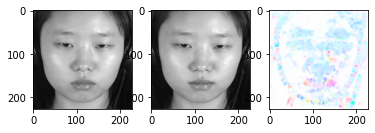

In [3]:
import cv2
import dlib
# 得到人脸掩膜
def get_face_mask(image_size, face_landmarks):
    """
    获取人脸掩模
    :param image_size: 图片大小
    :param face_landmarks: 68个特征点
    :return: image_mask, 掩模图片
    """
    mask = np.zeros(image_size, dtype=np.uint8)
    points = np.concatenate([face_landmarks[0:16], face_landmarks[26:17:-1]])
    cv2.fillPoly(img=mask, pts=[points], color=(255,255,255))
    return mask
# 获得人脸60个特征点
def get_face_landmarks(image, face_detector, shape_predictor):
    """
    获取人脸标志，68个特征点
    :param image: image
    :param face_detector: dlib.get_frontal_face_detector
    :param shape_predictor: dlib.shape_predictor
    :return: np.array([[],[]]), 68个特征点
    """
    dets = face_detector(image, 1)
    num_faces = len(dets)
    if num_faces == 0:
        print("Sorry, there were no faces found.")
        return None
    shape = shape_predictor(image, dets[0])
    face_landmarks = np.array([[p.x, p.y] for p in shape.parts()])
    return face_landmarks
predictor_path = '/home/developers/xianyun/spotting/core/data/data_tools/shape_predictor_68_face_landmarks.dat' # 模型路径
detector = dlib.get_frontal_face_detector()  # dlib的正向人脸检测器
predictor = dlib.shape_predictor(predictor_path)  # dlib的人脸形状检测器
# img1_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20/s27/0401/img1682.jpg'
# img2_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20/s27/0401/img1702.jpg'
img1_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20/s15/0502/img178.jpg'
img2_path = '/home/developers/xianyun/Data_zoo/CASME_sq/crop_faces_expand20/s15/0502/img190.jpg'
img1= cv2.imread(img1_path, 0)
img2= cv2.imread(img2_path, 0)
face_landmarks = get_face_landmarks(img1, detector, predictor)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(img1, cmap="gray")
plt.subplot(1,3,2)
plt.imshow(img2, cmap="gray")
flow = cv2.calcOpticalFlowFarneback(img1, img2, None, 0.5, 3, 5, 3, 5, 1.2, 0)
magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 
u, v = pol2cart(magnitude, angle)
final = np.zeros((227, 227, 2))

final[:,:,0] = u
final[:,:,1] = v
# points = np.concatenate([[[0,0]], face_landmarks[0:16], [[227,0], [227,227], [0,227]]])
# cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
# points = np.concatenate([[[0,0]], [face_landmarks[0]], face_landmarks[26:17:-1], [face_landmarks[16]], [[227,0]]])
# cv2.fillPoly(img=final, pts=[points], color=(0,0,0))
writeFlow('/home/developers/xianyun/Data_zoo' + '/0_1.flo', final)
visulize_flow_file('/home/developers/xianyun/Data_zoo/0_1.flo', '/home/developers/xianyun/Data_zoo')
img3= cv2.imread('/home/developers/xianyun/Data_zoo/0_1-vis.png')
# mask = np.zeros(img3.shape, dtype=np.uint8)

''' 
points = np.concatenate([[[0,0]], face_landmarks[0:16], [[227,0], [227,227], [0,227]]])
cv2.fillPoly(img=img3, pts=[points], color=(255,255,255))
points = np.concatenate([[[0,0]], [face_landmarks[0]], face_landmarks[26:17:-1], [face_landmarks[16]], [[227,0]]])
cv2.fillPoly(img=img3, pts=[points], color=(255,255,255))
# cv2.fillPoly(img=mask, pts=[points], color=(255,255,255))
# img3= cv2.bitwise_and(img3, mask)
plt.subplot(1,3,3)
plt.imshow(img3)
# plt.plot(face_landmarks[26:17:-1][:,0],face_landmarks[26:17:-1][:,1],'o')
'''
plt.subplot(1,3,3)
plt.imshow(img3)
